# E-comm Dataset

In [1]:
%%time
import findspark
findspark.init()

CPU times: total: 0 ns
Wall time: 2 ms


In [2]:
%%time
from pyspark.sql import SparkSession
from datetime import datetime
# user = "Heekang Park" # your name
# date = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
# spark = SparkSession.builder.master("yarn").appName(f"{user}-{date}").getOrCreate()

spark = SparkSession.builder.master('local[*]').getOrCreate()
spark

CPU times: total: 93.8 ms
Wall time: 3.4 s


## Read Dataset

In [3]:
%%time
df = spark.read.option("header", "true") \
                  .option("inferSchema", "true") \
                  .csv([
                        # "s3://ssds2-e-comm/2019-Dec.csv.gz",
                        # "s3://ssds2-e-comm/2019-Nov.csv.gz",
                        # "s3://ssds2-e-comm/2019-Oct.csv.gz",
                        # "s3://ssds2-e-comm/2020-Apr.csv.gz",
                        # "s3://ssds2-e-comm/2020-Feb.csv.gz",
                        # "s3://ssds2-e-comm/2020-Jan.csv.gz",
                        # "s3://ssds2-e-comm/2020-Mar.csv.gz",
                        # './data/e-comm-chair.csv.gz'
                        './data/e-comm-toys.csv.gz'
                    ])

print((df.count(), len(df.columns)))

(4115346, 9)
CPU times: total: 0 ns
Wall time: 11.4 s


In [6]:
# category_code 확인

df.select('category_code').distinct().collect()

[Row(category_code='kids.toys')]

In [4]:
# brand 확인

import pandas as pd

df.select('brand').distinct().show()

+-----------+
|      brand|
+-----------+
|       tmnt|
|    tuffoni|
|    blaster|
|    keenway|
|     rosato|
|       nerf|
|   avengers|
|     nasbro|
|    trikota|
|robocarpoli|
|     rieker|
|   skechers|
|         mz|
|    sp.lion|
|       jana|
|      rizmo|
| potatohead|
|      fleet|
|    greyder|
| yogasprout|
+-----------+
only showing top 20 rows



In [15]:
# event_type 확인
df.select('event_type').distinct().show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



In [16]:
# user_id 확인
df.select('user_id').distinct().show()

+---------+
|  user_id|
+---------+
|517823165|
|512552482|
|515524175|
|527077232|
|564368218|
|558038401|
|512762475|
|567202050|
|518263163|
|563993855|
|533338723|
|513602662|
|567076094|
|567475679|
|513841404|
|556031315|
|527055076|
|530506848|
|518800268|
|524481914|
+---------+
only showing top 20 rows



In [42]:
# 구매한 사람이 가장 많이 샀던 브랜드

df_brand = df.filter(df.event_type == 'purchase')\
    .select('event_type', 'user_id', 'brand')\
    .distinct()\
    .toPandas()

df_brand.sort_values(by='brand', ascending=False)

,event_type,user_id,brand
2683,purchase,519315823,zlatek
815,purchase,513217651,zlatek
3212,purchase,519553346,zlatek
5997,purchase,585885384,zlatek
573,purchase,514378046,zlatek
...,...,...,...
6070,purchase,518260514,None
6075,purchase,610205637,None
6085,purchase,559689903,None
6088,purchase,531883226,None


In [ ]:
# 가장 많은 돈을 쓴 사람이 가장 선호하는 브랜드


In [ ]:
# 장바구니에 담았다가 구매하는 사람들이 가장 선호하는 브랜드


## Preprocess and Summarize Data

In [5]:
# %%time
# # df_smartphone = df.filter(df.category_code == 'electronics.smartphone')
# df_smartphone = df.filter(df.category_code == 'kids.toys')
# df_smartphone.summary().show()

df_smartphone = df

In [6]:
%%time
from pyspark.sql.functions import length, col, max, lpad

print(df_smartphone.schema["product_id"].dataType)
print(df_smartphone.schema["category_id"].dataType)
print(df_smartphone.schema["user_id"].dataType)

df_smartphone = df_smartphone.withColumn("product_id", df_smartphone.product_id.cast('string'))
df_smartphone = df_smartphone.withColumn("category_id", df_smartphone.category_id.cast('string'))
df_smartphone = df_smartphone.withColumn("user_id", df_smartphone.user_id.cast('string'))

max_id_len = df_smartphone.withColumn("product_id_len", length(col("product_id")))\
                          .withColumn("category_id_len",length(col("category_id")))\
                          .withColumn("user_id_len",length(col("user_id")))\
                          .groupBy().agg(max("product_id_len"), max("category_id_len"), max("user_id_len")).collect()

len_pid, len_cid, len_uid = max_id_len[0]

df_smartphone = df_smartphone.withColumn("product_id", lpad(df_smartphone.product_id, len_pid, '0'))\
                             .withColumn("category_id", lpad(df_smartphone.category_id, len_cid, '0'))\
                             .withColumn("user_id", lpad(df_smartphone.user_id, len_uid, '0'))

df_smartphone = df_smartphone.cache()
df_smartphone.show()

IntegerType
LongType
IntegerType
+--------------------+----------+----------+-------------------+-------------+-----------+------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|category_code|      brand| price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+-------------+-----------+------+---------+--------------------+
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney| 10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney| 10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney| 10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:09:...|      view| 009002778|2053013553140465927|    kids.toys|     disney| 10.35|544828616|73e4e5d7-dc72-4ad...|
|2019-11-01 00:10:...|      view| 009002778|2053013553140465927|

In [7]:
%%time
from pyspark.sql.functions import col, when, count

df_smartphone.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df_smartphone.columns)).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|            0|910788|    0|      0|           2|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+

CPU times: total: 0 ns
Wall time: 995 ms


# Null이 있는 것들 개수
  * brand 컬럼에 910788개는 null이거나 값이 없다.
  * 나머지 컬럼들은 모두 값이 있다.
  * 컬럼명
    * event_time
    * event_type
    * product_id
    * category_id
    * category_code
    * brand
    * price
    * user_id
    * user_session

In [8]:
%%time
df_smartphone = df_smartphone.na.drop()
print((df_smartphone.count(), len(df_smartphone.columns)))

(3204556, 9)
CPU times: total: 0 ns
Wall time: 832 ms


# Null이 있는 row 제거
  * Null 있는 것들을 drop
  * 총 row 개수: 320,4556
  * 컬럼 개수: 9개

In [11]:
%%time
item_by_brand = df_smartphone.groupby("brand").agg(count("product_id").alias('pid_count'))
item_by_brand = item_by_brand.sort(item_by_brand.pid_count.desc())
item_by_brand.head(10)

CPU times: total: 0 ns
Wall time: 1.26 s


[Row(brand='lucente', pid_count=476570),
 Row(brand='epson', pid_count=188481),
 Row(brand='rastar', pid_count=160769),
 Row(brand='defacto', pid_count=159761),
 Row(brand='hp', pid_count=139399),
 Row(brand='escan', pid_count=108290),
 Row(brand='hasbro', pid_count=104872),
 Row(brand='hb', pid_count=91190),
 Row(brand='respect', pid_count=87088),
 Row(brand='canon', pid_count=84379)]

# 브랜드별 Product ID 개수
  * [Row(brand='lucente', pid_count=476570)
  * Row(brand='epson', pid_count=188481)
  * Row(brand='rastar', pid_count=160769)
  * Row(brand='defacto', pid_count=159761)
  * Row(brand='hp', pid_count=139399)
  * Row(brand='escan', pid_count=108290)
  * Row(brand='hasbro', pid_count=104872)
  * Row(brand='hb', pid_count=91190)
  * Row(brand='respect', pid_count=87088)
  * Row(brand='canon', pid_count=84379)]

In [12]:
%%time
from pyspark.sql.functions import countDistinct

df_smartphone.select(countDistinct("user_id")).show()
df_smartphone.select(countDistinct("user_session")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 771491|
+-----------------------+

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     1252248|
+----------------------------+

CPU times: total: 0 ns
Wall time: 6.5 s


# 사용자 수
  * 771491

# 사용자 세션 수
  * 1252248
  * 한 명의 사용자가 여러 세션을 만들었음을 의미함

In [18]:
%%time
from pyspark.sql.functions import to_timestamp, date_format

df_smartphone = df_smartphone.withColumn("dt", to_timestamp(col("event_time"),"yyyy-MM-dd HH:mm:ss z"))
df_smartphone = df_smartphone.withColumn("date", date_format('dt', 'yyyy-MM-dd'))
df_smartphone = df_smartphone.withColumn("time", date_format('dt', 'HH:mm:ss'))

# df_smartphone.head()
temp = pd.DataFrame(df_smartphone.head())
temp = temp.T
temp.columns = df_smartphone.columns
temp

CPU times: total: 0 ns
Wall time: 67 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 09:02:08,2019-11-01,09:02:08


In [22]:
%%time
from pyspark.sql.functions import dayofweek

# 요일 추가
# 0: 일요일, 1: 월요일, 2: 화요일, 3: 수요일, 4: 목요일, 5: 금요일: 6: 토요일
df_smartphone = df_smartphone.withColumn("weekday", dayofweek('dt'))
# df_smartphone.head()
temp = pd.DataFrame(df_smartphone.head()).T
temp.columns = df_smartphone.columns
temp

CPU times: total: 0 ns
Wall time: 60.1 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time,weekday
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 09:02:08,2019-11-01,09:02:08,6


In [28]:
%%time
from pyspark.sql.functions import udf

# 시간대 추가: time_session
# 3시간 단위로 시간대를 만들고, 어느 시간대인지 분류
def time_cut(h):
    session_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
    return session_labels[h // 3]

time_cut_udf = udf(time_cut)

df_smartphone = df_smartphone.withColumn("hour", date_format('dt', 'H').cast('int'))
df_smartphone = df_smartphone.withColumn("time_session", time_cut_udf(col("hour")).cast('string'))
temp = pd.DataFrame(df_smartphone.head(5))
temp.columns = df_smartphone.columns
temp

CPU times: total: 0 ns
Wall time: 565 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time,weekday,hour,time_session
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 09:02:08,2019-11-01,09:02:08,6,9,9-12
1,2019-11-01 00:02:14 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 09:02:14,2019-11-01,09:02:14,6,9,9-12
2,2019-11-01 00:02:21 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 09:02:21,2019-11-01,09:02:21,6,9,9-12
3,2019-11-01 00:09:13 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,544828616,73e4e5d7-dc72-4ad8-bbf7-95096ebce171,2019-11-01 09:09:13,2019-11-01,09:09:13,6,9,9-12
4,2019-11-01 00:10:10 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,544828616,dd25afb4-74d7-4878-80e8-85acb59b5a74,2019-11-01 09:10:10,2019-11-01,09:10:10,6,9,9-12


## Data Mining

1. Time distribution analysis

Daily distribution of number of events, by hour

In [30]:
%%time
# 시간, 보기, 카트추가, 구매를 컬럼으로 시간별 이벤트를 집계
view_by_hour = df_smartphone.filter(df_smartphone.event_type == 'view').groupby("hour").agg(count("event_type").alias('view'))
cart_by_hour = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby("hour").agg(count("event_type").alias('cart'))
purchase_by_hour = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby("hour").agg(count("event_type").alias('purchase'))
event_by_hour = view_by_hour.join(cart_by_hour, 'hour').join(purchase_by_hour, 'hour')

event_by_hour_df = event_by_hour.toPandas()
event_by_hour_df.sort_values(by='hour', ascending=True)

CPU times: total: 0 ns
Wall time: 5.54 s


,hour,view,cart,purchase
22,0,199404,5152,1512
2,1,206443,5301,1473
21,2,194066,4312,1378
6,3,166974,3970,1188
13,4,112712,2572,881
8,5,64518,1478,561
5,6,37710,854,297
16,7,25392,544,194
14,8,18561,381,130
11,9,19319,424,154


CPU times: total: 62.5 ms
Wall time: 569 ms


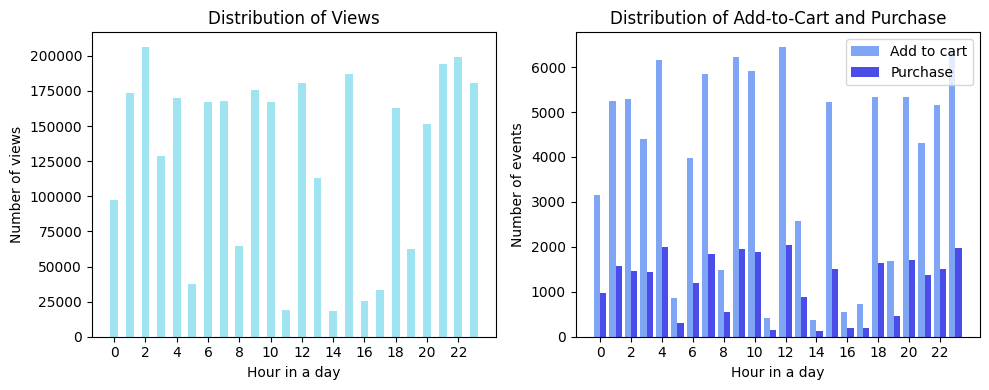

In [31]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ind = np.arange(event_by_hour_df.index.min(), event_by_hour_df.index.max()+1)
width = 0.5
view_bar = ax1.bar(ind, event_by_hour_df.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xlabel("Hour in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_hour_df.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_hour_df.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_xticklabels(ind[::2])
ax2.set_xlabel("Hour in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()

# 알게 된 것
  * 시간별 View 개수
    * 새벽 2시가 제일 높고, 20시 이후도 꽤 높다.
    * 새벽 5시가 낮다. 다들 자는 것일까?
    * 점심시간 전/후로 View 개수가 제일 낮다. 점심 시간대에는 다시 높아진다.
    * 오후 업무시간대 중 15시를 제외하면 View 개수가 낮다.

  * 장바구니 담기와 구매
    * 장바구니에 담은 것이 모두 구매로 이어지지 않는다.
    * 새벽 시간대가 의외로 구매가 높다.
    * 점심시간 전/후로는 구매가 적다.
    * 퇴근 시간 전 업무시간도 구매가 적다.
    * 20시 이후에 구매가 갑자기 증가한다.

Daily distribution of number of events, by time session

In [32]:
%%time
view_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'view').groupby("time_session").agg(count("event_type").alias('view'))
cart_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby("time_session").agg(count("event_type").alias('cart'))
purchase_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby("time_session").agg(count("event_type").alias('purchase'))
event_by_time_session = view_by_time_session.join(cart_by_time_session, 'time_session').join(purchase_by_time_session, 'time_session')

event_by_time_session_df = event_by_time_session.toPandas()
event_by_time_session_df

CPU times: total: 15.6 ms
Wall time: 9.08 s


,time_session,view,cart,purchase
0,12-15,377456,12899,4129
1,21-24,523473,15805,4728
2,15-18,517375,18524,5939
3,18-21,523443,18405,5748
4,0-3,599913,14765,4363
5,9-12,115025,2845,804
6,3-6,344204,8020,2630
7,6-9,81663,1779,621


CPU times: total: 15.6 ms
Wall time: 101 ms


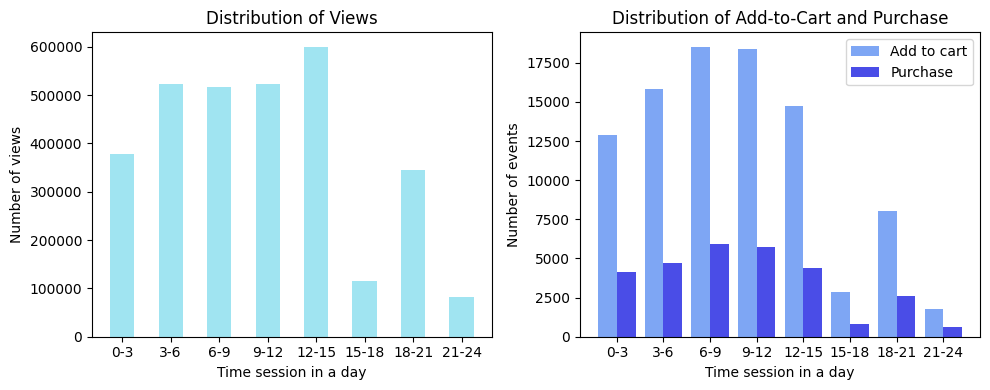

In [33]:
%%time
# plot
session_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ind = np.arange(event_by_time_session_df.index.nunique())
width = 0.5
ax1.bar(ind, event_by_time_session_df.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticklabels(session_labels)
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_time_session_df.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_time_session_df.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticklabels(session_labels)
ax2.set_xlabel("Time session in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()

# 알게 된 것
  * 시간대별(3시간 단위) View 개수
    * 새벽 시간대에 View는 점심 이후 시간대만큼 많이 본다.
    * 저녁식사 시간대에 View가 적다.
    * 보통 사람들이 자기 전에 View가 적다.
* 시간대별 장바구니 담기와 구매 개수
  * 새벽시간 대에 구매하는 비율이 압도적이다.
  * 오전에도 장바구니에 담는 것이 많다.
  * 저녁식사 시간 이후에는 View도 적으며, 구매도 적어진다.
  

CPU times: total: 15.6 ms
Wall time: 37.5 ms


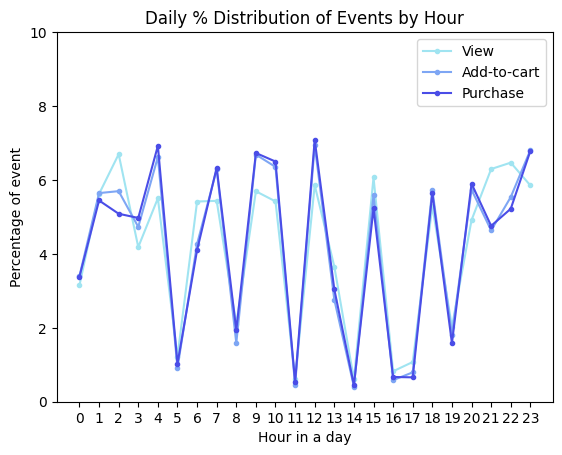

In [34]:
%%time
# combination showing ratio
event_by_hour_df['view_pct'] = event_by_hour_df.view / sum(event_by_hour_df.view) * 100
event_by_hour_df['cart_pct'] = event_by_hour_df.cart/ sum(event_by_hour_df.cart) * 100
event_by_hour_df['purchase_pct'] = event_by_hour_df.purchase / sum(event_by_hour_df.purchase) * 100

hours = np.arange(0, 24)
view_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(hours)
plt.ylim([0, 10])
plt.xlabel("Hour in a day")
plt.ylabel("Percentage of event")
plt.title("Daily % Distribution of Events by Hour")
plt.legend()

# 알게 된 것
  * 시간별 이벤트
    * 일반적으로 자기 전에 구매보다는 View를 많이 하는 듯 하다.
    * 새벽시간 ~ 오전에 구매를 많이 한다.

CPU times: total: 0 ns
Wall time: 24 ms


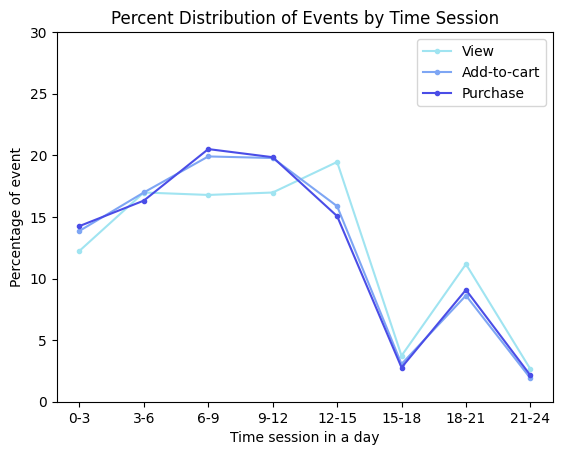

In [35]:
%%time
# combination showing ratio
event_by_time_session_df['view_pct'] = event_by_time_session_df.view / sum(event_by_time_session_df.view) * 100
event_by_time_session_df['cart_pct'] = event_by_time_session_df.cart/ sum(event_by_time_session_df.cart) * 100
event_by_time_session_df['purchase_pct'] = event_by_time_session_df.purchase / sum(event_by_time_session_df.purchase) * 100

time_sessions = np.arange(0, len(session_labels))
view_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(time_sessions, session_labels)
plt.ylim([0, 30])
plt.xlabel("Time session in a day")
plt.ylabel("Percentage of event")
plt.title("Percent Distribution of Events by Time Session")
plt.legend()

# 알게 된 것
  * 새벽~ 오전에는 구매를 더 많이 한다.
  * 점심시간 ~ 자기 전까지는 View를 많이 한다.

Daily distribution of events, facet by weekday

In [36]:
%%time
import pandas as pd

weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_dict = dict(zip(weekdays, list(range(1,8))))

view_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'view').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_view')).toPandas()
view_by_ss_wkdy['weekday'] = view_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
view_by_ss_wkdy['weekday'] = pd.Categorical(view_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
view_by_ss_wkdy['time_session'] = pd.Categorical(view_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
view_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

cart_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_cart')).toPandas()
cart_by_ss_wkdy['weekday'] = cart_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
cart_by_ss_wkdy['weekday'] = pd.Categorical(cart_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
cart_by_ss_wkdy['time_session'] = pd.Categorical(cart_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
cart_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

purchase_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_purchase')).toPandas()
purchase_by_ss_wkdy['weekday'] = purchase_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
purchase_by_ss_wkdy['weekday'] = pd.Categorical(purchase_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
purchase_by_ss_wkdy['time_session'] = pd.Categorical(purchase_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
purchase_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

purchase_by_ss_wkdy.head(8)

CPU times: total: 0 ns
Wall time: 7.75 s


,weekday,time_session,num_purchase
31,Sunday,0-3,566
26,Sunday,3-6,338
34,Sunday,6-9,91
38,Sunday,9-12,97
21,Sunday,12-15,552
39,Sunday,15-18,892
4,Sunday,18-21,827
27,Sunday,21-24,655


In [37]:
%%time
# events per weekday
view_per_wkdy = view_by_ss_wkdy.groupby("weekday")['num_view'].sum().to_frame()
cart_per_wkdy = cart_by_ss_wkdy.groupby("weekday")['num_cart'].sum().to_frame()
purchase_per_wkdy = purchase_by_ss_wkdy.groupby("weekday")['num_purchase'].sum().to_frame()
event_by_weekday = pd.concat([view_per_wkdy, cart_per_wkdy, purchase_per_wkdy], axis=1)
event_by_weekday

CPU times: total: 0 ns
Wall time: 10 ms


<timed exec>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,num_view,num_cart,num_purchase
weekday,,,
Sunday,445427,13345,4018
Monday,446655,13932,4326
Tuesday,450023,13161,4130
Wednesday,448740,12858,4238
Thursday,443083,13189,4256
Friday,428116,13277,4015
Saturday,420508,13280,3979


CPU times: total: 15.6 ms
Wall time: 50.5 ms


Text(0.5, 1.0, 'Weekly Distribution of Events')

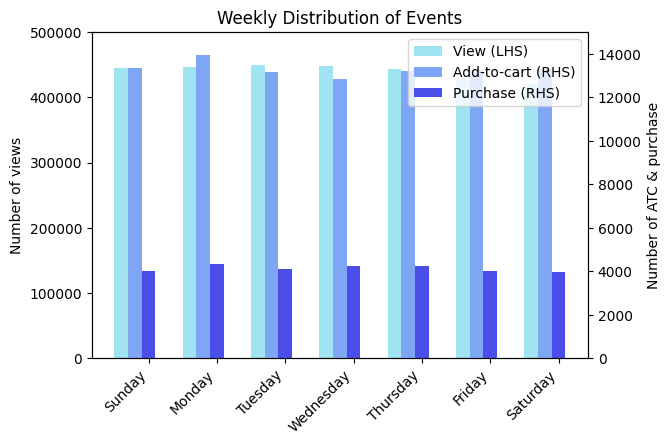

In [40]:
%%time
# plot events per weekday
fig, ax1 = plt.subplots()

width = 0.2
xticks = np.arange(0, len(weekdays))

view_wkdy_plot = ax1.bar(xticks, event_by_weekday.num_view, width=width, color='#A0E4F1')
ax1.set_ylim([0, 500_000])
ax1.set_ylabel("Number of views")

ax2 = ax1.twinx()
cart_wkdy_plot = ax2.bar(xticks+width, event_by_weekday.num_cart, width=width, color='#7EA6F4')
purchase_wkdy_plot = ax2.bar(xticks+width*2, event_by_weekday.num_purchase, width=width, color='#4A4DE7')
ax2.set_ylim([0, 15_000])
ax2.set_ylabel("Number of ATC & purchase")

plt.legend((view_wkdy_plot, cart_wkdy_plot, purchase_wkdy_plot), ('View (LHS)', 'Add-to-cart (RHS)', 'Purchase (RHS)'))
plt.xticks(xticks+width*2, weekdays)
fig.autofmt_xdate(rotation=45)
plt.title('Weekly Distribution of Events')

# 알게된 것
  * 장난감은 요일에 상관없이 꾸준히 구매한다.

CPU times: total: 78.1 ms
Wall time: 298 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

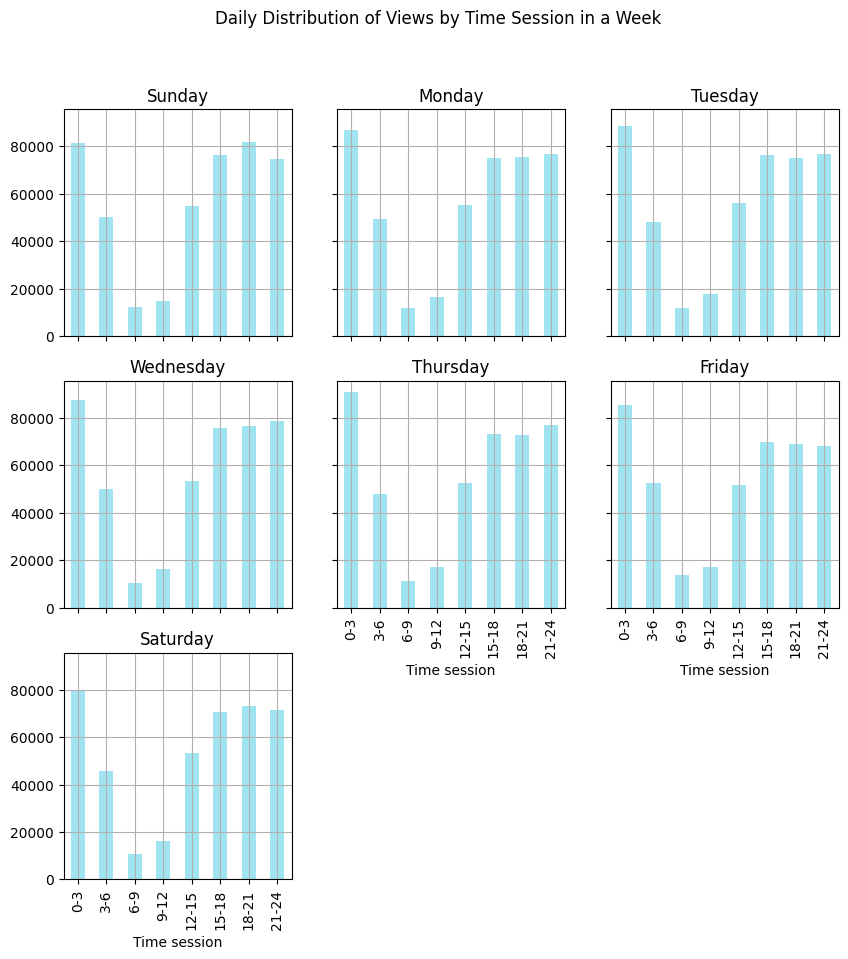

In [41]:
%%time
# Daily split
view_by_ss_wkdy_pvt = view_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_view')
view_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#A0E4F1',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Views by Time Session in a Week',
    grid=True
)

CPU times: total: 46.9 ms
Wall time: 218 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

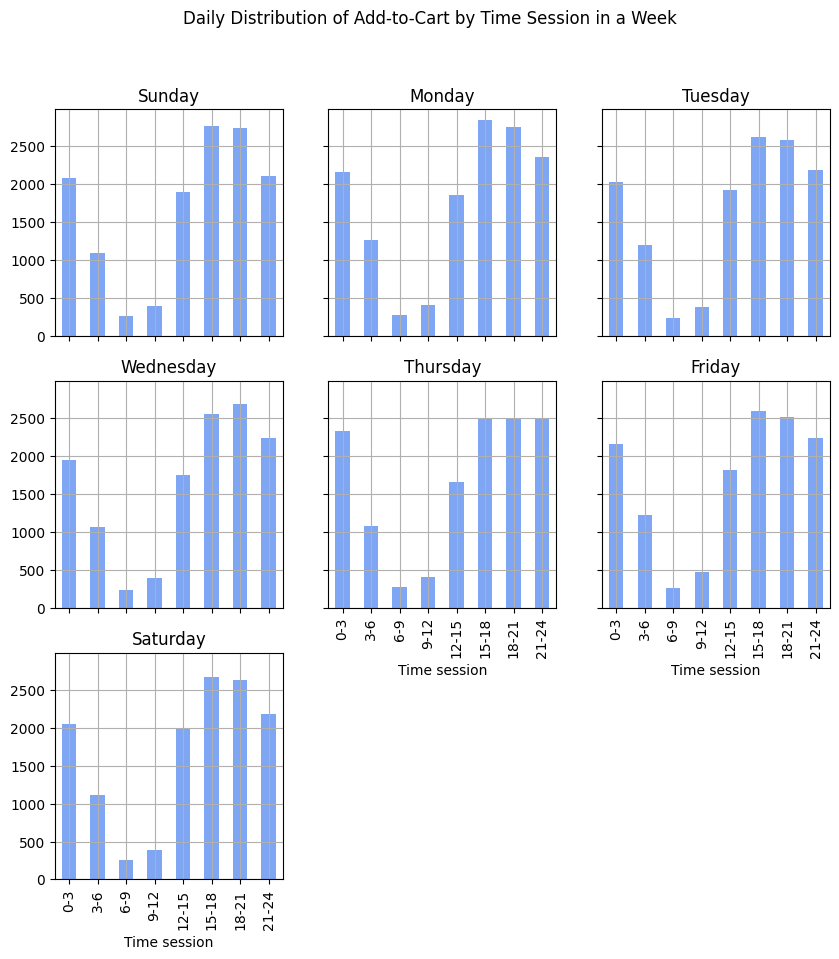

In [42]:
%%time
# Daily split
cart_by_ss_wkdy_pvt = cart_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_cart')
cart_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#7EA6F4',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Add-to-Cart by Time Session in a Week',
    grid=True
)

CPU times: total: 46.9 ms
Wall time: 241 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

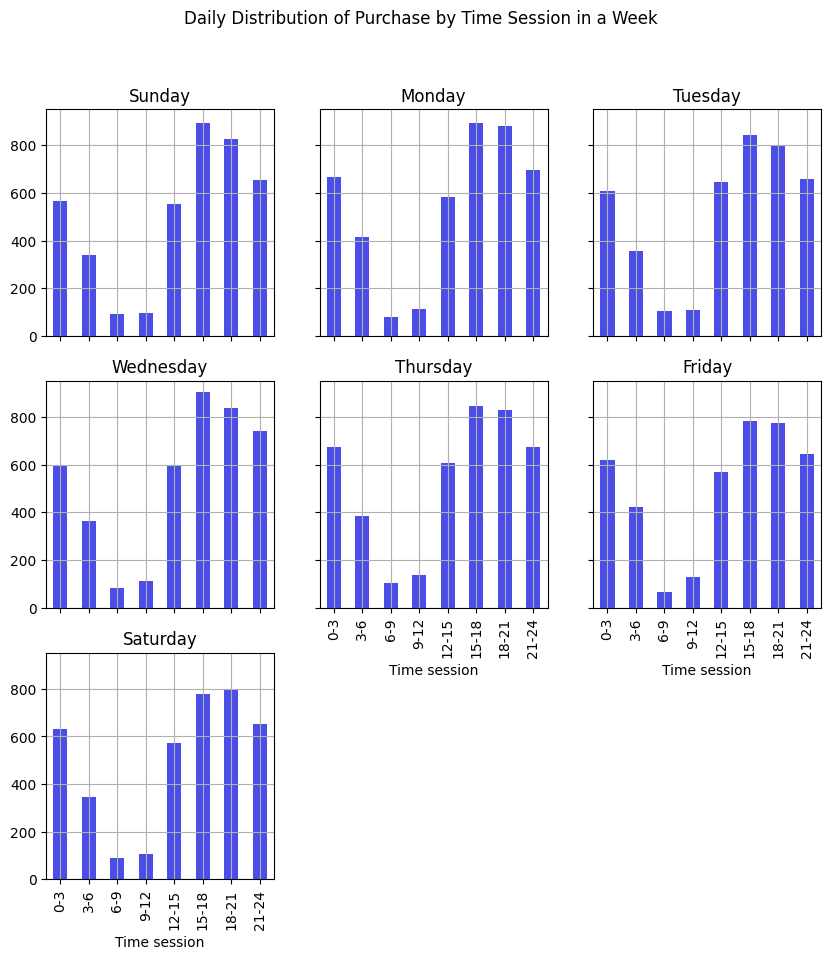

In [43]:
%%time
# Daily split
purchase_by_ss_wkdy_pvt = purchase_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_purchase')
purchase_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#4A4DE7',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Purchase by Time Session in a Week',
    grid=True
)

# 알게 된 것
  * 장난감은 요일에 상관 없다.


Hypo testing with Chi-square test

H0 - shoppers have the time tendency for different events in a day

$H_0$: 쇼핑하는 사람들은 보기/장바구니 담기/구매에 대한 선호 시간이 있다.

In [44]:
def chi2_test(obs, exp, main_cat: int = 0, alpha = 0.05):
    from scipy.stats import chisquare

    chi, pval = chisquare(f_obs=obs, f_exp=exp)
    if pval < alpha:
        print(f"Statistically significant under level of sig={alpha} ({pval}). H0 rejected.")
    else:
        print(f"NOT statistically significant under level of sig={alpha} ({pval}). H0 not rejected.")

    return chi, pval

In [45]:
%%time
def half_of_day(x):
    return 2 if x > 12 else 1

half_of_day_udf = udf(half_of_day)

df_smartphone = df_smartphone.withColumn("half_of_day", half_of_day_udf("hour"))

def event_retype(x):
    return 2 if x in ['cart', 'purchase'] else 1

event_retype_udf = udf(event_retype)

df_smartphone = df_smartphone.withColumn("event_retype", event_retype_udf("event_type"))

CPU times: total: 0 ns
Wall time: 34 ms


In [46]:
%%time
data_test_psdf = df_smartphone[["half_of_day", "event_retype"]]
data_test_pd = data_test_psdf.toPandas()

CPU times: total: 3.09 s
Wall time: 16 s


In [47]:
%%time
chi_crosstab = pd.crosstab(data_test_pd.half_of_day, data_test_pd.event_retype, margins=True)
chi_crosstab

CPU times: total: 234 ms
Wall time: 824 ms


event_retype,1,2,All
half_of_day,,,
1,1237833,39968,1277801
2,1844719,82036,1926755
All,3082552,122004,3204556


In [49]:
%%time
obs = chi_crosstab.iloc[0, :]
exp = chi_crosstab.iloc[1, :]

obs = obs*exp.sum()/obs.sum() # for matching counts

pval, chi = chi2_test(obs, exp)

Statistically significant under level of sig=0.05 (0.0). H0 rejected.
CPU times: total: 46.9 ms
Wall time: 15.8 s


# $H_0$ 기각
  * 쇼핑하는 사람들은 시간과 상관 없이 보기, 장바구니 담기, 구매를 한다.

In [50]:
%%time
data_test_psdf = df_smartphone[["weekday", "event_retype"]]
data_test_pd = data_test_psdf.toPandas()

CPU times: total: 3.3 s
Wall time: 13.1 s


In [51]:
%%time
chi_ctab_wk = pd.crosstab(data_test_pd.weekday, data_test_pd.event_retype, margins=True)
chi_ctab_wk

CPU times: total: 438 ms
Wall time: 756 ms


event_retype,1,2,All
weekday,,,
1,445427,17363,462790
2,446655,18258,464913
3,450023,17291,467314
4,448740,17096,465836
5,443083,17445,460528
6,428116,17292,445408
7,420508,17259,437767
All,3082552,122004,3204556


In [52]:
%%time
pval, chi = chi2_test(chi_ctab_wk.iloc[:-1, 0] * (chi_ctab_wk.iloc[:-1, 1].sum()/chi_ctab_wk.iloc[:-1, 0].sum()), chi_ctab_wk.iloc[:-1, 1])

Statistically significant under level of sig=0.05 (5.81012073751334e-18). H0 rejected.
CPU times: total: 0 ns
Wall time: 2 ms


# $H_0$ 기각
  * 요일은 보기/장바구니 담기/구매와 관계 없이 발생한다.

Conclusion: shoppers have different time preference for viewing vs. ATC & check-outs when shopping on e-comm platform.

## Funnel Analysis

Add-to-cart rate (ATCR) and cart abandonment rate

now we're utilizing PySpark Pandas API

In [54]:
%%time
import pyspark.pandas as ps

data_test = df_smartphone.to_pandas_on_spark()

user_session_by_time_session = data_test.drop_duplicates(subset=['user_session']).groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session"})
user_session_by_time_session.head()

G:\dev\spark-3.2.4-bin-hadoop3.2\python\pyspark\pandas\__init__.py:47: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


CPU times: total: 109 ms
Wall time: 3.74 s


,num_user_session
time_session,
12-15,163868
21-24,210608
15-18,221649
18-21,220752
0-3,223144


In [55]:
%%time
cart_sessions = data_test[data_test.event_type == 'cart']
user_session_cart_by_time_session = cart_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_cart"})
user_session_cart_by_time_session.head()

CPU times: total: 15.6 ms
Wall time: 135 ms


,num_user_session_cart
time_session,
12-15,12899
21-24,15805
15-18,18524
18-21,18405
0-3,14765


In [56]:
%%time
ps.set_option('compute.ops_on_diff_frames', True) # only needed for pyspark pandas

atcr_by_time_session = ps.concat([user_session_by_time_session, user_session_cart_by_time_session], axis=1)
atcr_by_time_session['atcr'] = atcr_by_time_session.num_user_session_cart / atcr_by_time_session.num_user_session * 100
atcr_by_time_session.head()

CPU times: total: 31.2 ms
Wall time: 200 ms


,num_user_session,num_user_session_cart,atcr
time_session,,,
0-3,223144,14765,6.616803
12-15,163868,12899,7.871580
15-18,221649,18524,8.357358
18-21,220752,18405,8.337410
21-24,210608,15805,7.504463


In [57]:
%%time
purchase_sessions = data_test[data_test.event_type == 'purchase']
user_session_purchase_by_time_session = purchase_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_purchase"})
user_session_purchase_by_time_session.head()

CPU times: total: 0 ns
Wall time: 135 ms


,num_user_session_purchase
time_session,
12-15,4129
21-24,4728
15-18,5939
18-21,5748
0-3,4363


In [58]:
%%time
ctcr_by_time_session = ps.concat([user_session_cart_by_time_session, user_session_purchase_by_time_session], axis=1)
ctcr_by_time_session['ctcr'] = ctcr_by_time_session.num_user_session_purchase / ctcr_by_time_session.num_user_session_cart * 100
ctcr_by_time_session.head()

CPU times: total: 15.6 ms
Wall time: 171 ms


,num_user_session_cart,num_user_session_purchase,ctcr
time_session,,,
0-3,14765,4363,29.549611
12-15,12899,4129,32.010233
15-18,18524,5939,32.061110
18-21,18405,5748,31.230644
21-24,15805,4728,29.914584


In [59]:
%%time
ctcr_by_time_session['car'] = 100 - ctcr_by_time_session.ctcr
ctcr_by_time_session

CPU times: total: 0 ns
Wall time: 43 ms


,num_user_session_cart,num_user_session_purchase,ctcr,car
time_session,,,,
0-3,14765,4363,29.549611,70.450389
12-15,12899,4129,32.010233,67.989767
15-18,18524,5939,32.061110,67.938890
18-21,18405,5748,31.230644,68.769356
21-24,15805,4728,29.914584,70.085416
3-6,8020,2630,32.793017,67.206983
6-9,1779,621,34.907251,65.092749
9-12,2845,804,28.260105,71.739895


CPU times: total: 0 ns
Wall time: 87.2 ms


([<matplotlib.axis.XTick at 0x1894d364f70>,
 [Text(0, 0, '0-3'),
  Text(1, 0, '3-6'),
  Text(2, 0, '6-9'),
  Text(3, 0, '9-12'),
  Text(4, 0, '12-15'),
  Text(5, 0, '15-18'),
  Text(6, 0, '18-21'),
  Text(7, 0, '21-24')])

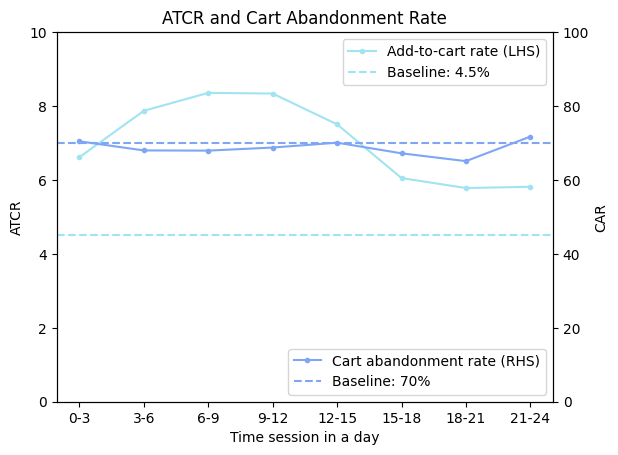

In [62]:
%%time
# visualization
fig, ax1 = plt.subplots()

avg_atcr = 4.5
ax1.plot(atcr_by_time_session.index, atcr_by_time_session.atcr, marker='.', color='#A0E4F1', label='Add-to-cart rate (LHS)')
ax1.axhline(y=avg_atcr, linestyle='--', color='#A0E4F1', linewidth=1.5, label=f'Baseline: {avg_atcr}%')
# ax1.set_ylim([0, 8])
ax1.set_ylim([0, 10])
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("ATCR")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.plot(ctcr_by_time_session.index, ctcr_by_time_session.car, marker='.', color='#7EA6F4', label='Cart abandonment rate (RHS)')
ax2.axhline(y=70, linestyle='--', color='#7EA6F4', linewidth=1.5, label='Baseline: 70%')
ax2.set_ylim([0, 100])
ax2.set_ylabel("CAR")
ax2.legend(loc="lower right")

plt.title("ATCR and Cart Abandonment Rate")
plt.xticks(time_sessions, session_labels)

# 그래프로 알게 된 것
  * 장바구니에 담은 것은 시간대에 상관 없이 사지 않는다.
  * 장바구니에 담는 것은 새벽~오후 시간대에 많다.

Time interval between each decision to act

In [75]:
%%time
from pyspark.sql.functions import concat

df_test = df_smartphone.limit(20000).cache()

df_test = df_test.withColumn("product_id", df_test.product_id.cast('string'))
df_test = df_test.withColumn("category_id", df_test.category_id.cast('string'))
df_test = df_test.withColumn("user_id", df_test.user_id.cast('string'))

max_id_len = df_test.withColumn("product_id_len", length(col("product_id")))\
                    .withColumn("category_id_len", length(col("category_id")))\
                    .withColumn("user_id_len", length(col("user_id")))\
                    .groupBy().agg(max("product_id_len"), max("category_id_len"), max("user_id_len")).collect()

len_pid, len_cid, len_uid = max_id_len[0]

df_test = df_test.withColumn("product_id", lpad(df_test.product_id, len_pid, '0'))\
                 .withColumn("category_id", lpad(df_test.category_id, len_cid, '0'))\
                 .withColumn("user_id", lpad(df_test.user_id, len_uid, '0'))

df_test = df_test.withColumn("uid", concat(col("user_id"), col("brand"), col("product_id")))
uid_view = df_test.filter(df_test.event_type == 'view').select("uid").distinct()
uid_cart = df_test.filter(df_test.event_type == 'cart').select("uid").distinct()
uid_purchase = df_test.filter(df_test.event_type == 'purchase').select("uid").distinct()

uid_common = uid_view.intersect(uid_cart).intersect(uid_purchase).collect()
uid_common = [ u.uid for u in uid_common ]
len(uid_common)

TypeError: 'str' object is not callable

# 알게 된 것: 상품 보는 사람과 구매하는 사람은 다르다.
  * 상품을 본 사람과 장바구니에 담아 구매하는 사람은 다른 사람이다?

Filter userid+productid+brand with all three events (view-cart-purchase, with purchase being the end)

Calculate number of sessions between first view to end purchase. What’s the average user session numbers before a customer place an order?

Calculate the time gap between decisions: a) First view – ATC b) ATC – purchase What’s the average time interval between each decision? May use box plot

Calculate the price change from first view, ATC and final payment. Is there any price changes that possibly affect consumer’s decision to buy?

Brand analysis (simply)

In [65]:
%%time
data_filtered = df_test.filter(df_test.uid.isin(uid_common))
print((data_filtered.count(), len(data_filtered.columns)))

(0, 18)
CPU times: total: 15.6 ms
Wall time: 36 ms


# 알게 된 것: 상품 조회부터 구매까지 모두 다 한 사람은 없다.

In [68]:
%%time
from datetime import datetime
import timedelta

def dt64_to_dt(datetime64):
    return datetime.utcfromtimestamp(datetime64.tolist()/1e9)

header = [
            'uid',
            'time_view_to_cart',
            'cart_duration',
            'time_cart_to_purchase',
            'time_view_to_purchase',
            'num_user_sessions',
            'price_change_view_to_cart',
            'price_change_cart_to_purchase'
            ]

interval_df = pd.DataFrame(columns=header)

for i in uid_common:
    data_selected = data_filtered.filter(data_filtered.uid == i).sort("event_time").toPandas()
    purchase_index = data_selected[data_selected.event_type == 'purchase'].index[-1]
    data_selected = data_selected.loc[:purchase_index, :]

    # time gap
    try:
        time_view = dt64_to_dt(data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_view = np.nan

    try:
        time_cart_first = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_first = np.nan

    try:
        time_cart_final = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='last')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_final = np.nan

    try:
        time_purchase = dt64_to_dt(data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_purchase = np.nan

    try:
        cart_duration = timedelta.Timedelta(time_cart_final - time_cart_first).total.seconds
    except (AttributeError, TypeError):
        cart_duration = np.nan

    try:
        view_to_cart = timedelta.Timedelta(time_cart_first - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_cart = np.nan

    try:
        cart_to_purchase = timedelta.Timedelta(time_purchase - time_cart_final).total.seconds
    except (AttributeError, TypeError):
        cart_to_purchase = np.nan

    try:
        view_to_purchase = timedelta.Timedelta(time_purchase - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_purchase = np.nan

    # user session gap
    user_session_gap = data_selected.user_session.nunique()

    # price change
    try:
        price_view = data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_view = np.nan

    try:
        price_cart = data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_cart = np.nan

    try:
        price_purchase = data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_purchase = np.nan

    price_change_view_to_cart = price_cart / price_view - 1
    price_change_cart_to_purchase = price_purchase / price_cart - 1

    # combine and append
    record = [
                i,
                view_to_cart,
                cart_duration,
                cart_to_purchase,
                view_to_purchase,
                user_session_gap,
                price_change_view_to_cart,
                price_change_cart_to_purchase
                ]

    interval_df.loc[interval_df.shape[0]] = record

interval_df.head(10)

CPU times: total: 0 ns
Wall time: 3.01 ms


,uid,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase


In [69]:
%%time
interval_df = interval_df.reset_index()
interval_df.set_index('uid', inplace=True)
interval_df = interval_df.astype(float).dropna(how='any')
interval_df.describe()

CPU times: total: 0 ns
Wall time: 8 ms


,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
%%time
interval_df_new = interval_df.copy()

cols_to_winsor = ['time_view_to_cart', 'cart_duration', 'time_cart_to_purchase', 'time_view_to_purchase']
time_bound = [300, 120, 300, 900]
for i in range(len(cols_to_winsor)):
    # interval_df_new[col] = mstats.winsorize(interval_df_new[col], limits=[0, 0.15])
    col = cols_to_winsor[i]
    timelim = time_bound[i]
    interval_df_new.loc[interval_df_new[col] > timelim, col] = timelim
    interval_df_new.loc[interval_df_new[col] < 0, col] = 0
interval_df_new.describe()

CPU times: total: 0 ns
Wall time: 8 ms


,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: total: 0 ns
Wall time: 112 ms


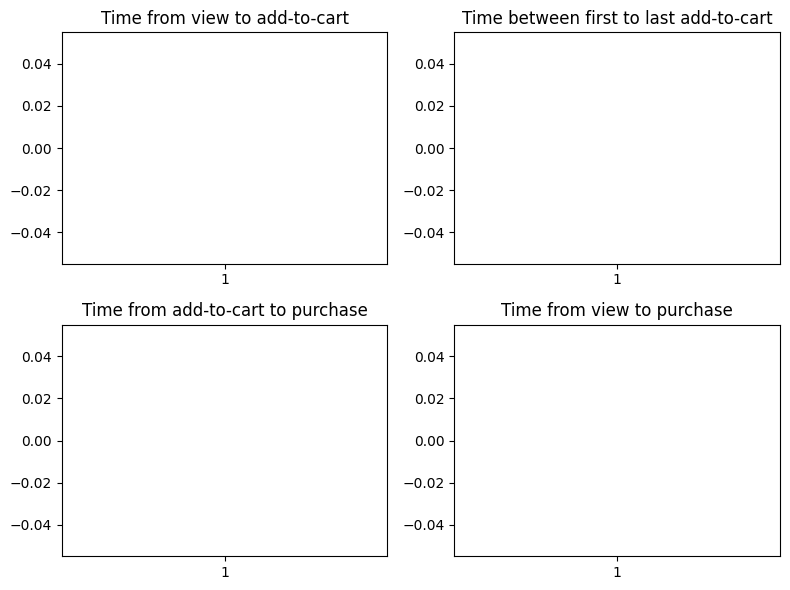

In [71]:
%%time
flierprops = dict(marker='+', markerfacecolor='g', markersize=15, linestyle='none', markeredgecolor='r')
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax1.boxplot(interval_df_new.time_view_to_cart, flierprops=flierprops)
ax1.set_title('Time from view to add-to-cart')

ax2 = fig.add_subplot(222)
ax2.boxplot(interval_df_new.cart_duration, flierprops=flierprops)
ax2.set_title('Time between first to last add-to-cart')

ax3 = fig.add_subplot(223)
ax3.boxplot(interval_df_new.time_cart_to_purchase, flierprops=flierprops)
ax3.set_title('Time from add-to-cart to purchase')

ax4 = fig.add_subplot(224)
ax4.boxplot(interval_df_new.time_view_to_purchase, flierprops=flierprops)
ax4.set_title('Time from view to purchase')

fig.tight_layout()

Done!

In [76]:
df_smartphone.count()

3204556

# 요일별로 가장 많이 구매하는 브랜드

In [82]:
temp = df_smartphone.select("brand").groupBy("brand").count().show()

+-----------+-----+
|      brand|count|
+-----------+-----+
|       tmnt| 2523|
|    tuffoni| 5339|
|    blaster| 1389|
|    keenway| 9030|
|     rosato|  211|
|       nerf|10218|
|   avengers|  720|
|     nasbro|  287|
|    trikota|   17|
|robocarpoli|35126|
|     rieker|13137|
|   skechers| 5409|
|         mz|22578|
|    sp.lion| 3089|
|       jana|  174|
|      rizmo|  156|
| potatohead|   16|
|      fleet|  107|
|    greyder| 5026|
| yogasprout|  330|
+-----------+-----+
only showing top 20 rows



In [100]:
df_smartphone.columns

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'dt',
 'date',
 'time',
 'weekday',
 'hour',
 'time_session',
 'half_of_day',
 'event_retype']

In [103]:
df_smartphone.select('event_type').distinct().show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



In [119]:
df_purchase = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupBy("brand").count().toPandas()
df_view = df_smartphone.filter(df_smartphone.event_type == 'view').groupBy("brand").count().toPandas()
df_cart = df_smartphone.filter(df_smartphone.event_type == 'cart').groupBy("brand").count().toPandas()

In [124]:
df_top10_purchase_brand = df_purchase.sort_values(by='count', ascending=False)
df_top10_purchase_brand = df_top10_purchase_brand.rename(columns={"count": "purchase"})
df_top10_purchase_brand = df_top10_purchase_brand.reset_index(drop=True)
df_top10_purchase_brand = df_top10_purchase_brand.head(10)
df_top10_purchase_brand = pd.DataFrame(df_top10_purchase_brand)
df_top10_purchase_brand

,brand,purchase
0,lucente,9199
1,epson,3592
2,hp,1557
3,rastar,1095
4,escan,986
5,canon,817
6,respect,813
7,hb,753
8,edufun,710
9,adidas,498


In [145]:
df_top10_view = df_view.sort_values(by='count', ascending=False)
df_top10_view = df_top10_view.rename(columns={"count": "view"})
df_top10_view = df_top10_view.reset_index(drop=True)
df_top10_view = df_top10_view.head(10)
df_top10_view

,brand,view
0,lucente,447552
1,epson,173715
2,defacto,158534
3,rastar,153905
4,hp,132730
5,escan,104616
6,hasbro,100972
7,hb,87905
8,respect,83968
9,adidas,81546


In [146]:
df_top10_cart = df_cart.sort_values(by='count', ascending=False)
df_top10_cart = df_top10_cart.rename(columns={"count": "cart"})
df_top10_cart = df_top10_cart.reset_index(drop=True)
df_top10_cart = df_top10_cart.head(10)
df_top10_cart

,brand,cart
0,lucente,19819
1,epson,11174
2,rastar,5769
3,hp,5112
4,hasbro,3436
5,canon,2716
6,escan,2688
7,hb,2532
8,respect,2307
9,edufun,2179


# 가장 많이 구매하는 브랜드는 압도적으로 lucente

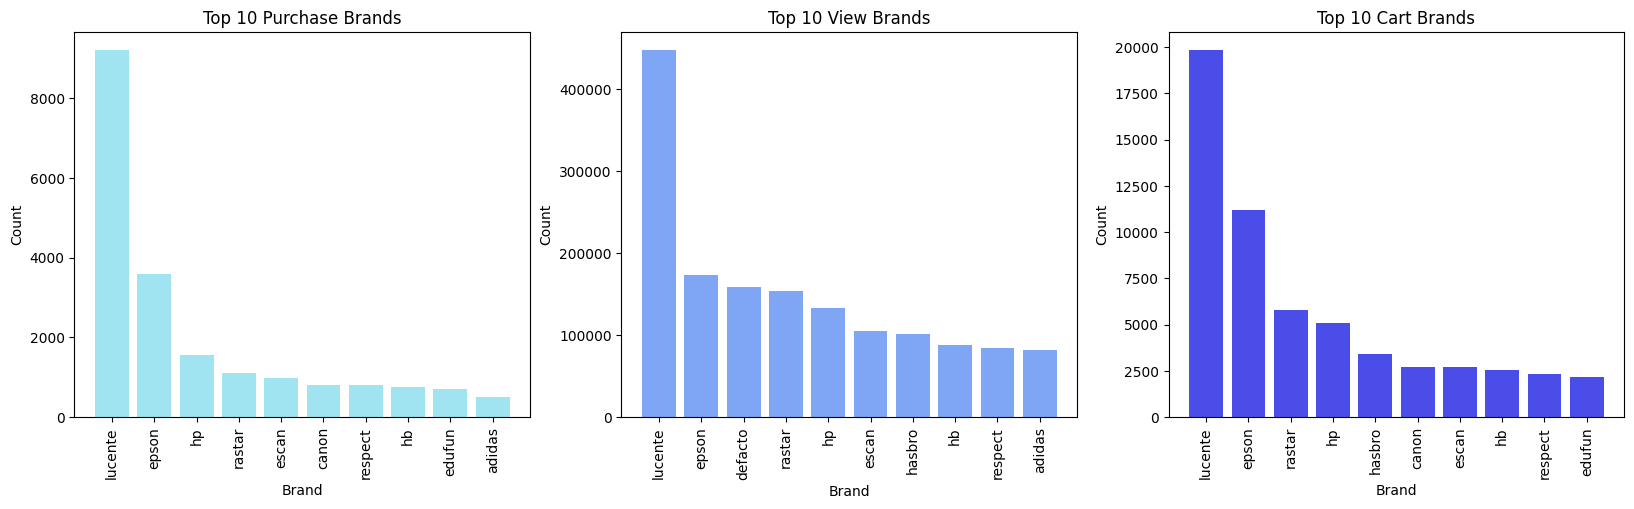

In [149]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax1.set_title('Top 10 Purchase Brands')
ax1.set_xlabel('Brand')
ax1.set_ylabel('Count')
ax1.bar(df_top10_purchase_brand.brand, df_top10_purchase_brand['purchase'], color='#A0E4F1')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(132)
ax2.set_title('Top 10 View Brands')
ax2.set_xlabel('Brand')
ax2.set_ylabel('Count')
ax2.bar(df_top10_view.brand, df_top10_view['view'], color='#7EA6F4')
plt.xticks(rotation=90)

ax3 = fig.add_subplot(133)
ax3.set_title('Top 10 Cart Brands')
ax3.set_xlabel('Brand')
ax3.set_ylabel('Count')
ax3.bar(df_top10_cart.brand, df_top10_cart['cart'], color='#4A4DE7')
plt.xticks(rotation=90)

plt.show()

# 가장 많이 구매한 브랜드는 무슨 요일에 가장 많이 조회했고, 무슨 요일에 샀을까?